___
# Data Visualization
___

## Objectives
* Satisfy business rerquirement 1 - 

    *"The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew."*

## Inputs
* inputs/cherry_leaves_dataset/train
* inputs/cherry_leaves_dataset/test
* inputs/cherry_leaves_dataset/validation

## Outputs
* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between healthy leaves and ones infected with powdery mildew.
* Generate code that satisfies business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

___
### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Set Working Directory
Change the working directory from its current folder to its parent folder.

In [2]:
current_dir = os.getcwd()
current_dir

'/Users/oksanaerm/ML/ML-mildew-detection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/Users/oksanaerm/ML/ML-mildew-detection'

### Set input and output paths
***Inputs***

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'


***Outputs***

In [6]:
version = 'v1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)

version v1 already exists. Create a new version


### Set labels

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


___
## Data Visualization of image dataset
___
### Image shape embeddings
Compute the average size (height and width in pixels) of images in the training dataset 

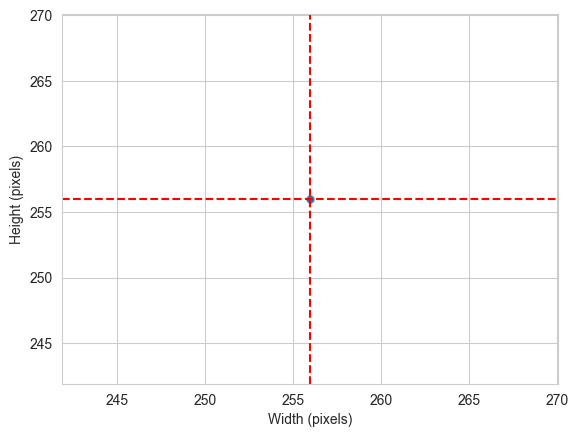

Width average: 256 
Height average: 256


In [8]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/' + label):
    img = imread(train_path + '/' + label + '/' + image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)  # image height
    dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

In [9]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save the 'image_shape' value to a file

In [10]:
joblib.dump(value=image_shape,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

___ 
### Mean and variability of images per label
Load and preprocess image data from a directory into numpy arrays

In [11]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      # Limit the number of images per label to reduce processing time
      if counter < n_images_per_label:
       # Load and resize the image
        img = image.load_img(my_data_dir + '/' + label +
                             '/' + image_filename, target_size=new_size)
                             
        # Normalize the pixel values to between 0 and 1
        if image.img_to_array(img).max() > 1:
          img_resized = image.img_to_array(img) / 255
        else:
          img_resized = image.img_to_array(img)
        
        # Append the image and label to the numpy arrays
        X = np.append(X, img_resized).reshape(-1,
                                              new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

2023-03-30 01:01:58.648431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load image shapes and labels into an array

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


Plot the mean and variability of images per label

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
  # iterate over unique labels in y
  for label_to_display in np.unique(y):
    sns.set_style("white")
    # create a boolean mask that selects images with the current label
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    arr = X[boolean_mask]
    
    # compute the average and standard deviation image for the selected images
    avg_img = np.mean(arr, axis=0)
    std_img = np.std(arr, axis=0)

    # plot the average and standard deviation images side by side
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    # optionally save the image to a file
    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                  bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")


==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


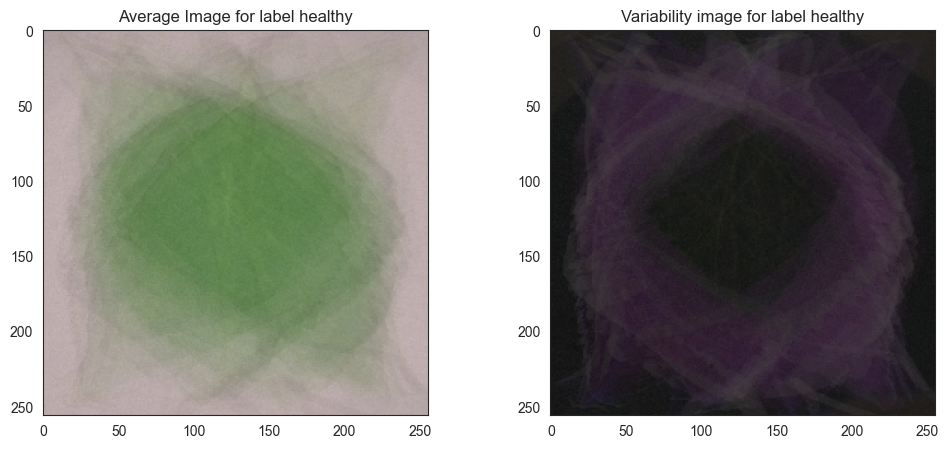

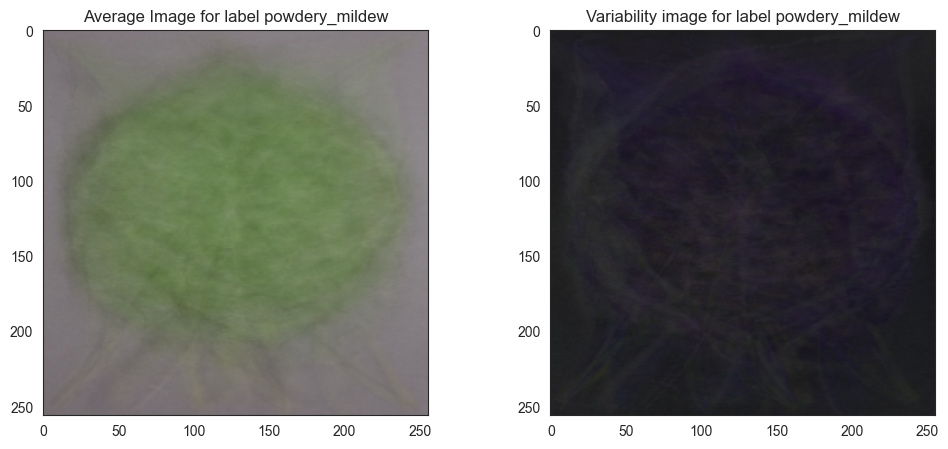

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)

___
### Difference between healthy and infected leaves

In [ ]:
def subset_image_label(X, y, label_to_display):
  """
  Select all images from X that have the label label_to_display in y.
  """
  y = y.reshape(-1, 1, 1)
  boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
  """
  Calculate the average image for two different labels in X, and plot the difference between them.
  """
  sns.set_style("white")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(
        f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis=0)

  # calculate mean from label2
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis=0)

  # Calculate the difference between the mean images and plot them.
  difference_mean = label1_avg - label2_avg
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

In [ ]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

___
### Image montage
Plot an image montage of healthy and infected leaves

In [ ]:
import itertools
import random
# Set the style of the plots to white
sns.set_style("white")

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
  # Get a list of all the labels in the directory
  labels = os.listdir(dir_path)

  # Check if the label to display exists in the directory
  if label_to_display in labels:

    # Check if the montage space is greater than the number of images in the 
    # label folder
    images_list = os.listdir(dir_path+'/' + label_to_display)
    if nrows * ncols < len(images_list):
      # Randomly select a subset of the images to display
      img_idx = random.sample(images_list, nrows * ncols)
    else:
      # Print an error message if the number of spaces in the montage is less 
      # than or equal to the number of images in the label folder
      print(
          f"Decrease nrows or ncols to create your montage. \n"
          f"There are {len(images_list)} in your subset. "
          f"You requested a montage with {nrows * ncols} spaces")
      return

    # Create a list of axes indices based on the number of rows and columns
    list_cols = range(0, ncols)
    plot_idx = list(itertools.product(list_rows, list_cols))
    # Create a Figure and display the images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for x in range(0, nrows*ncols):
      # Load and plot the image at the given index
      img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
      img_shape = img.shape
      axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
      axes[plot_idx[x][0], plot_idx[x][1]].set_title(
          f"Width {img_shape[1]}px x Height {img_shape[0]}px")
      axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
      axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
    # Adjust the layout of the subplots and show the montage
    plt.tight_layout()
    plt.show()

  else:
    # Print an error message if the label to display is not in the directory
    print("The label you selected doesn't exist.")
    print(f"The existing options are: {labels}")

In [ ]:
for label in labels:
  print(label)
  image_montage(dir_path=train_path,
                label_to_display=label,
                nrows=3, ncols=3,
                figsize=(10, 15)
                )
  print("\n")

____
# Push files to GitHub

git add .

git commit -m "Add data visualisation notebook."

git push

___
### Next Step

* [03 - Model Training](03%20-%20Model%20Training.ipynb)
